# **Osteoarthritis Severity Classification - Data Preparation**

**George Ford - Data Preparation Pipeline**

### 🏥 Clinical Decision Support System
Building an end-to-end ML pipeline for automated osteoarthritis severity assessment from knee X-rays, with integrated clinical decision support and LLM-powered treatment recommendations for healthcare professionals.

**Citation:** Gornale, Shivanand; Patravali, Pooja (2020), Digital Knee X-ray Images, Mendeley Data, V1, https://doi.org/10.17632/t9ndx37v5h.1

---

## Overview

This notebook prepares and preprocesses knee X-ray images for osteoarthritis severity classification using **PyTorch**. The dataset contains images classified into 5 categories (0=Normal, 1=Doubtful, 2=Mild, 3=Moderate, 4=Severe) by two medical experts.

### Key Features:
- Expert consensus filtering - Only uses images where both experts agree
- Demo patient selection - Curated patients for clinical application showcase
- Wide image splitting - Converts 640×161 dual-knee images into single-knee images
- Automated image preprocessing - Cropping, centering, and resizing
- Quality assurance - Visual verification and duplicate detection
- Stratified train/validation/test splits - Maintains class balance (75/12.5/12.5)
- PyTorch-ready datasets - Optimized for modern GPU training

---

## Expected Directory Structure

**Input (from Kaggle download):**
```
data/kaggle/
├── MedicalExpert-I/
│   ├── 0Normal/
│   ├── 1Doubtful/
│   ├── 2Mild/
│   ├── 3Moderate/
│   └── 4Severe/
└── MedicalExpert-II/
    ├── 0Normal/
    ├── 1Doubtful/
    ├── 2Mild/
    ├── 3Moderate/
    └── 4Severe/
```

**Output (processed for training):**
```
data/consensus/
├── demo_patients/         # Curated patients for clinical showcase
├── train/                 # 75% - Expert consensus images
├── val/                   # 12.5% - Expert consensus images  
├── test/                  # 12.5% - Expert consensus images
└── expert_disagreements/  # remove images where experts disagree
```

---

# Table of Contents

1. [Setup and Imports](#setup)
2. [Dataset Exploration](#exploration)
3. [Color Image Detection & Conversion](#color)
4. [Wide Image Splitting](#splitting)
5. [Duplicate Detection & Expert Consensus](#consensus)
6. [Demo Patient Selection](#demo-patients)
7. [Stratified Train/Val/Test Split](#stratification)
8. [Image Preprocessing & Quality Control](#preprocessing)
9. [Summary and Next Steps](#summary)


## **Setup and Imports** <a id="setup"></a>

Initializes the core environment, libraries, and configurations for data preparation and preprocessing.

- Load required libraries
- Configure image settings and class labels for 5 severity grades
- Auto-detect repository structure and establish working directories
- Set reproducibility seeds for training consistency
- Display runtime environment status and available GPU resources
- Define train/validation/test ratios and demo patient configuration


In [1]:
# Core Python Libraries
import os
import shutil
import hashlib
import random
import warnings
import json
from pathlib import Path
from collections import Counter, defaultdict
warnings.filterwarnings('ignore')

# Data Science Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Image Processing
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import seaborn as sns

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

# Configuration
plt.style.use('default')
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("Data Preparation Setup Complete")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Data Preparation Setup Complete
PyTorch version: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 4070


In [2]:
# Project Configuration

# Auto-detect repository root by looking for data directory
possible_roots = [
    Path.cwd(),
    Path(__file__).parent if '__file__' in globals() else None,
    Path.cwd().parent,
]
possible_roots = [p for p in possible_roots if p is not None]

repo_root = None
for start_dir in possible_roots:
    current_check = start_dir
    
    while current_check != current_check.parent:
        if (current_check / 'data').exists():
            repo_root = current_check
            break
        current_check = current_check.parent
    
    if repo_root:
        break

if not repo_root:
    common_locations = [
        Path.cwd() / '..',
        Path.cwd() / '../..',
        Path.home() / 'Documents' / 'GitHub' / 'osteoarthritis-severity',
    ]
    
    for location in common_locations:
        if location.exists() and (location / 'data').exists():
            repo_root = location.resolve()
            break
    
    if not repo_root:
        raise FileNotFoundError("Could not find 'data' directory. Please ensure you're running from the repository root.")

# Get repository name for relative path display
repo_name = repo_root.name

# Directory structure
DATA_DIR = repo_root / "data"
KAGGLE_DIR = DATA_DIR / "kaggle"
CONSENSUS_DIR = DATA_DIR / "consensus"
EXPERT_DISAGREEMENTS_DIR = CONSENSUS_DIR / "expert_disagreements"

# Image processing settings
IMG_EXTS = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
TARGET_SIZE = (224, 224)
WIDE_IMG_SIZE = (640, 161)
CLASS_NAMES = ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
EXPERTS = ['MedicalExpert-I', 'MedicalExpert-II']

# Data splitting configuration
TRAIN_RATIO = 0.75
VAL_RATIO = 0.125
TEST_RATIO = 0.125
RANDOM_SEED = 42

# Demo patient configuration
DEMO_PATIENTS_PER_CLASS = 3
TOTAL_DEMO_PATIENTS = DEMO_PATIENTS_PER_CLASS * len(CLASS_NAMES)

print(f"Repository: {repo_name}")
print(f"Data split: {TRAIN_RATIO:.1%}/{VAL_RATIO:.1%}/{TEST_RATIO:.1%}")
print(f"Demo patients: {DEMO_PATIENTS_PER_CLASS} per class ({TOTAL_DEMO_PATIENTS} total)")
print(f"Classes: {CLASS_NAMES}")
print(f"Target image size: {TARGET_SIZE}")

# Display relative paths for reference
print(f"\nData directories:")
print(f"  Original data: {repo_name}/data/kaggle")
print(f"  Processed data: {repo_name}/data/consensus")
print(f"  Demo patients: {repo_name}/data/consensus/demo_patients")


Repository: osteoarthritis-severity
Data split: 75.0%/12.5%/12.5%
Demo patients: 3 per class (15 total)
Classes: ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
Target image size: (224, 224)

Data directories:
  Original data: osteoarthritis-severity/data/kaggle
  Processed data: osteoarthritis-severity/data/consensus
  Demo patients: osteoarthritis-severity/data/consensus/demo_patients


## **Dataset Exploration** <a id="exploration"></a>

Inspects the raw Kaggle dataset to ensure quality and consistency before preprocessing.

- Recursively scans all image files to count extensions and dimensions  
- Validates expected expert/class folder structure  
- Confirms image types, sizes, and resolution diversity  
- Reports expert-wise and overall class distribution  
- Ensures readiness for downstream consensus filtering and preprocessing


In [3]:
def summarize_files(path, exts_only=False):
    """
    Walk path recursively and report unique file extensions and image dimensions.
    
    Args:
        path: Directory path to analyze
        exts_only: If True, only prints extension summary
    """
    ext_counter = Counter()
    size_counter = Counter()
    
    for dirpath, _, filenames in os.walk(path):
        for fname in filenames:
            full = os.path.join(dirpath, fname)
            _, ext = os.path.splitext(fname)
            ext = ext.lower() or "<no-ext>"
            ext_counter[ext] += 1
            
            if not exts_only:
                try:
                    with Image.open(full) as img:
                        size_counter[img.size] += 1
                except (IOError, OSError):
                    pass
    
    print("=== File extensions ===")
    for ext, cnt in ext_counter.most_common():
        print(f"{ext:>8} : {cnt}")
    
    if not exts_only:
        print("\n=== Image dimensions (WxH) ===")
        for (w,h), cnt in size_counter.most_common():
            print(f"{w}×{h} : {cnt}")

def analyze_dataset_structure(data_dir):
    """Analyze the structure and content of the Kaggle dataset directory"""
    data_dir = Path(data_dir)
    stats = {
        'total_images': 0,
        'experts': {},
        'classes': {},
        'file_extensions': Counter(),
        'image_sizes': Counter()
    }
    
    print(f"Analyzing Kaggle dataset: {repo_name}/data/kaggle")
    
    for expert_dir in data_dir.iterdir():
        if expert_dir.is_dir() and expert_dir.name in EXPERTS:
            expert_stats = {}
            
            for class_dir in expert_dir.iterdir():
                if class_dir.is_dir() and class_dir.name in CLASS_NAMES:
                    class_count = 0
                    
                    for img_path in class_dir.glob('*'):
                        if img_path.suffix.lower() in IMG_EXTS:
                            try:
                                with Image.open(img_path) as img:
                                    stats['image_sizes'][img.size] += 1
                                    stats['file_extensions'][img_path.suffix.lower()] += 1
                                    class_count += 1
                                    stats['total_images'] += 1
                            except Exception:
                                continue
                    
                    expert_stats[class_dir.name] = class_count
                    
                    if class_dir.name not in stats['classes']:
                        stats['classes'][class_dir.name] = 0
                    stats['classes'][class_dir.name] += class_count
            
            stats['experts'][expert_dir.name] = expert_stats
    
    return stats

print("Dataset summary functions defined")


Dataset summary functions defined


In [4]:
# Check if Kaggle data exists
if not KAGGLE_DIR.exists():
    print(f"Kaggle data directory not found: {repo_name}/data/kaggle")
    print("Please download the dataset from Kaggle and extract to:")
    print(f"   {repo_name}/data/kaggle")
    print("Dataset: https://www.kaggle.com/datasets/orvile/digital-knee-x-ray-images")
else:
    print(f"Kaggle data directory found: {repo_name}/data/kaggle")
    
    # Analyze the dataset
    print("\n" + "="*50)
    print("KAGGLE DATASET ANALYSIS")
    print("="*50)
    
    # File summary
    summarize_files(KAGGLE_DIR)
    
    print("\n" + "-"*40)
    
    # Detailed structure analysis
    dataset_stats = analyze_dataset_structure(KAGGLE_DIR)
    
    print(f"\nTotal images found: {dataset_stats['total_images']}")
    print(f"File extensions: {dict(dataset_stats['file_extensions'])}")
    print(f"Image dimensions: {dict(dataset_stats['image_sizes'])}")
    
    # Expert breakdown
    print("\nExpert Classifications:")
    for expert, classes in dataset_stats['experts'].items():
        print(f"  {expert}:")
        for class_name, count in classes.items():
            print(f"    {class_name}: {count}")
    
    # Overall class distribution
    print("\nClass Distribution:")
    for class_name in CLASS_NAMES:
        count = dataset_stats['classes'].get(class_name, 0)
        print(f"  {class_name}: {count}")


Kaggle data directory found: osteoarthritis-severity/data/kaggle

KAGGLE DATASET ANALYSIS
=== File extensions ===
    .png : 3300
    .csv : 1

=== Image dimensions (WxH) ===
300×162 : 2928
640×161 : 372

----------------------------------------
Analyzing Kaggle dataset: osteoarthritis-severity/data/kaggle

Total images found: 3300
File extensions: {'.png': 3300}
Image dimensions: {(300, 162): 2928, (640, 161): 372}

Expert Classifications:
  MedicalExpert-I:
    0Normal: 514
    1Doubtful: 477
    2Mild: 232
    3Moderate: 221
    4Severe: 206
  MedicalExpert-II:
    0Normal: 503
    1Doubtful: 488
    2Mild: 232
    3Moderate: 221
    4Severe: 206

Class Distribution:
  0Normal: 1017
  1Doubtful: 965
  2Mild: 464
  3Moderate: 442
  4Severe: 412


## Color Image Detection & Grayscale Conversion <a id="color"></a>

Checks whether any images in the dataset are stored in RGB format instead of grayscale, and converts them if needed.

- **`detect_color_images()`**: Scans for images with color channels (RGB)
- **`convert_to_grayscale()`**: Converts RGB images to single-channel grayscale


In [5]:

## Color Image Detection & Conversion Functions

def detect_color_images(data_dir):
    """
    Detect color images in the dataset (some X-rays may be in RGB format).
    
    Args:
        data_dir: Directory to scan for color images
        
    Returns:
        List of color image paths
    """
    def is_color_image(img_path):
        """Check if image is color (RGB) or grayscale"""
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
            if img is None:
                return False
            
            # Grayscale if R=G=B everywhere
            b, g, r = cv2.split(img)
            return not (np.array_equal(b, g) and np.array_equal(g, r))
        except:
            return False
    
    color_images = []
    total_images = 0
    
    # Scan all image files
    for img_path in Path(data_dir).rglob('*'):
        if img_path.suffix.lower() in IMG_EXTS:
            total_images += 1
            if is_color_image(img_path):
                color_images.append(img_path)
    
    color_count = len(color_images)
    color_pct = (color_count / total_images * 100) if total_images > 0 else 0
    
    print(f"Color detection: {color_count}/{total_images} ({color_pct:.1f}%) color images")
    
    return color_images

def convert_to_grayscale(color_images):
    """
    Convert color images to grayscale.
    
    Args:
        color_images: List of paths to color images
        
    Returns:
        Number of successfully converted images
    """
    converted_count = 0
    
    for img_path in color_images:
        try:
            # Load as color
            img_color = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
            if img_color is None:
                continue
                
            # Convert to grayscale
            img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
            
            # Save as grayscale
            cv2.imwrite(str(img_path), img_gray)
            
            print(f"{img_path.name} → grayscale")
            converted_count += 1
            
        except Exception as e:
            print(f"Error converting {img_path.name}: {e}")
    
    if converted_count > 0:
        print(f"Converted {converted_count} images to grayscale")
    
    return converted_count

print("Color image detection and conversion functions defined")

Color image detection and conversion functions defined


In [6]:
# Execute color detection and conversion on Kaggle data
if KAGGLE_DIR.exists():
    print("Standardizing image format...")
    
    # Step 1: Detect and convert color images
    print("\nStep 1: Color image detection and conversion")
    color_images = detect_color_images(KAGGLE_DIR)
    
    if color_images:
        convert_to_grayscale(color_images)
        print("Color images converted to grayscale")
    else:
        print("All images are already grayscale")
    
    print(f"\nImage format standardization complete")
    print(f"All images in {repo_name}/data/kaggle are now in consistent grayscale format")
    
else:
    print("Skipping color conversion - Kaggle data not found")


Standardizing image format...

Step 1: Color image detection and conversion
Color detection: 6/3300 (0.2%) color images
ModerateG3 (19).png → grayscale
ModerateG3 (213).png → grayscale
ModerateG3 (68).png → grayscale
ModerateG3 (19).png → grayscale
ModerateG3 (213).png → grayscale
ModerateG3 (68).png → grayscale
Converted 6 images to grayscale
Color images converted to grayscale

Image format standardization complete
All images in osteoarthritis-severity/data/kaggle are now in consistent grayscale format


## Wide Image Splitting <a id="splitting"></a>

Some X-ray images (640×161) contain both left and right knee joints simultaneously. This section identifies and splits those into separate left and right images.

### **Approach:**
1. **Identify wide images** - Find images with dimensions 640×161
2. **Split methodology** - Remove center gap (40px) and create left/right crops
3. **Naming convention** - Save as `<original_name>_L.ext` and `<original_name>_R.ext`
4. **Verify output** – Ensure each wide image produces two cropped images


In [7]:
def crop_wide_images(source_dir, gap_width=40):
    """
    Split 640×161 images into left and right halves by removing center gap.
    
    Args:
        source_dir: Directory to process
        gap_width: Width of center gap to remove (default 40px)
    
    Returns:
        Dictionary with processing statistics
    """
    source_dir = Path(source_dir)
    stats = {
        'originals_found': 0,
        'left_created': 0,
        'right_created': 0,
        'errors': 0
    }
    
    print(f"Processing wide images in: {repo_name}/data/kaggle")
    
    # Process all images in expert/class directories
    for expert_dir in source_dir.iterdir():
        if not expert_dir.is_dir() or expert_dir.name not in EXPERTS:
            continue
            
        for class_dir in expert_dir.iterdir():
            if not class_dir.is_dir() or class_dir.name not in CLASS_NAMES:
                continue
                
            print(f"  {expert_dir.name}/{class_dir.name}")
            
            for img_path in class_dir.glob('*'):
                if not img_path.suffix.lower() in IMG_EXTS:
                    continue
                    
                try:
                    with Image.open(img_path) as img:
                        w, h = img.size
                        
                        # Only process wide images
                        if (w, h) != WIDE_IMG_SIZE:
                            continue
                            
                        stats['originals_found'] += 1
                        
                        # Calculate split points
                        mid = w // 2
                        left_crop = img.crop((0, 0, mid - gap_width//2, h))
                        right_crop = img.crop((mid + gap_width//2, 0, w, h))
                        
                        # Save left and right halves
                        stem, ext = img_path.stem, img_path.suffix
                        left_path = img_path.with_name(f"{stem}_L{ext}")
                        right_path = img_path.with_name(f"{stem}_R{ext}")
                        
                        left_crop.save(left_path)
                        right_crop.save(right_path)
                        
                        stats['left_created'] += 1
                        stats['right_created'] += 1
                        
                except Exception as e:
                    print(f"    Error processing {img_path.name}: {e}")
                    stats['errors'] += 1
    
    return stats

def preview_splits(source_dir, n_samples=3, gap_width=40):
    """Preview the splitting process with sample images"""
    # Find wide images for preview
    wide_images = []
    for expert_dir in Path(source_dir).iterdir():
        if not expert_dir.is_dir() or expert_dir.name not in EXPERTS:
            continue
        for class_dir in expert_dir.iterdir():
            if not class_dir.is_dir() or class_dir.name not in CLASS_NAMES:
                continue
            for img_path in class_dir.glob('*'):
                if img_path.suffix.lower() in IMG_EXTS:
                    try:
                        with Image.open(img_path) as img:
                            if img.size == WIDE_IMG_SIZE:
                                wide_images.append(img_path)
                    except:
                        continue
    
    if not wide_images:
        print("No wide images found for preview")
        return
    
    samples = random.sample(wide_images, min(n_samples, len(wide_images)))
    
    fig, axes = plt.subplots(len(samples), 3, figsize=(15, 5*len(samples)))
    if len(samples) == 1:
        axes = axes.reshape(1, -1)
    
    for row, img_path in enumerate(samples):
        img = np.array(Image.open(img_path))
        h, w = img.shape[:2]
        mid = w // 2
        half = gap_width // 2
        
        # Original with split lines
        ax = axes[row, 0]
        ax.imshow(img, cmap='gray')
        ax.axvline(x=mid-half, color='red', linewidth=2, label='Split lines')
        ax.axvline(x=mid+half, color='red', linewidth=2)
        ax.set_title(f"Original: {img_path.name}")
        ax.axis('off')
        
        # Left crop
        left = img[:, :mid-half]
        axes[row, 1].imshow(left, cmap='gray')
        axes[row, 1].set_title(f"Left: {img_path.stem}_L{img_path.suffix}")
        axes[row, 1].axis('off')
        
        # Right crop
        right = img[:, mid+half:]
        axes[row, 2].imshow(right, cmap='gray')
        axes[row, 2].set_title(f"Right: {img_path.stem}_R{img_path.suffix}")
        axes[row, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Wide image splitting functions defined")


Wide image splitting functions defined


Previewing wide image splitting...


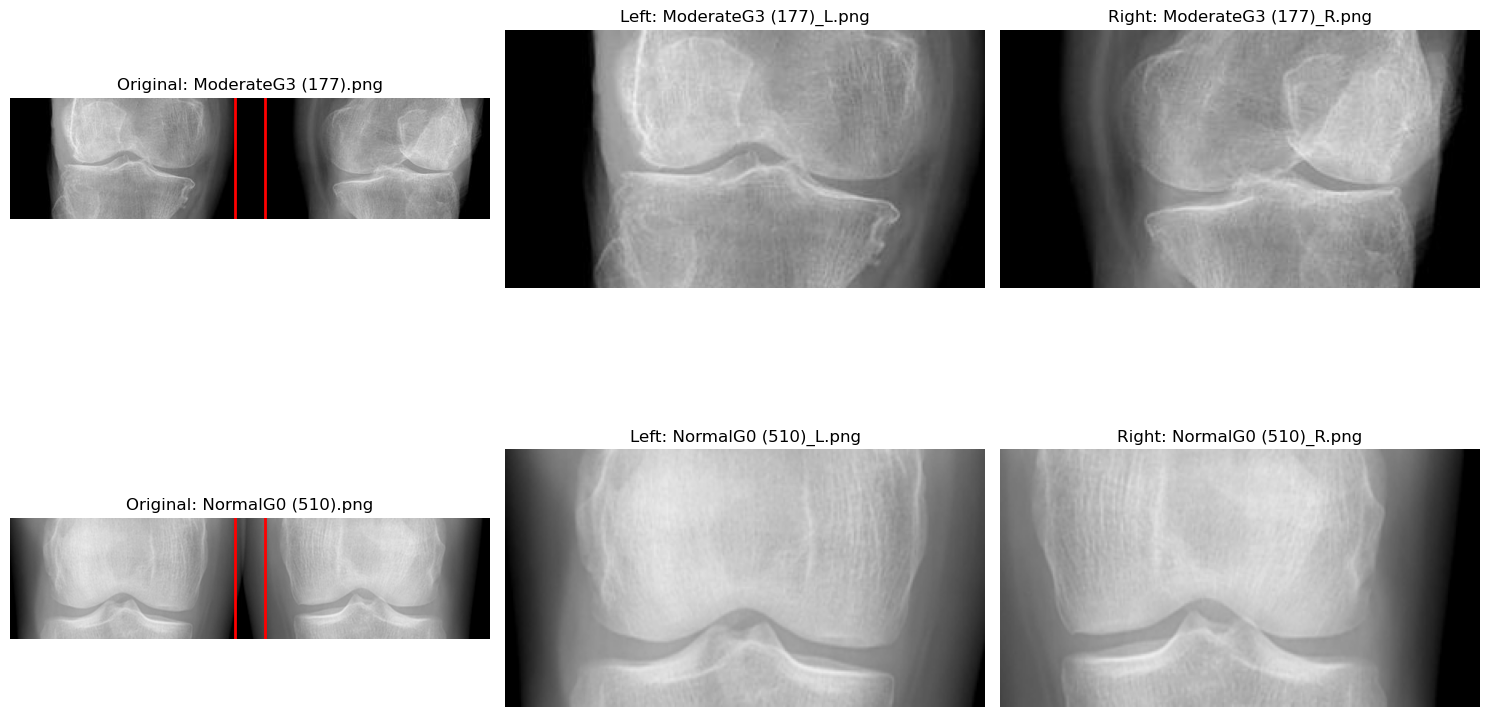


Executing wide image splitting...
Processing wide images in: osteoarthritis-severity/data/kaggle
  MedicalExpert-I/0Normal
  MedicalExpert-I/1Doubtful
  MedicalExpert-I/2Mild
  MedicalExpert-I/3Moderate
  MedicalExpert-I/4Severe
  MedicalExpert-II/0Normal
  MedicalExpert-II/1Doubtful
  MedicalExpert-II/2Mild
  MedicalExpert-II/3Moderate
  MedicalExpert-II/4Severe

Wide image splitting complete
Statistics:
Original wide images found: 372
Left images created: 372
Right images created: 372
Errors encountered: 0
All wide images successfully split

Dataset after splitting:
=== File extensions ===
    .png : 4044
    .csv : 1

=== Image dimensions (WxH) ===
300×162 : 2928
300×161 : 744
640×161 : 372


In [8]:
# Execute wide image splitting if Kaggle data exists
if KAGGLE_DIR.exists():
    print("Previewing wide image splitting...")
    preview_splits(KAGGLE_DIR, n_samples=2)
    
    print("\nExecuting wide image splitting...")
    split_stats = crop_wide_images(KAGGLE_DIR)
    
    print(f"\nWide image splitting complete")
    print(f"Statistics:")
    print(f"Original wide images found: {split_stats['originals_found']}")
    print(f"Left images created: {split_stats['left_created']}")
    print(f"Right images created: {split_stats['right_created']}")
    print(f"Errors encountered: {split_stats['errors']}")
    
    # Verify the split worked correctly
    if split_stats['originals_found'] > 0:
        expected_total = split_stats['originals_found'] * 2
        actual_total = split_stats['left_created'] + split_stats['right_created']
        if expected_total == actual_total:
            print("All wide images successfully split")
        else:
            print(f"Expected {expected_total} new images, got {actual_total}")
    
    # Re-analyze dataset after splitting
    print(f"\nDataset after splitting:")
    summarize_files(KAGGLE_DIR)
else:
    print("Skipping wide image splitting - Kaggle data not found")


## Duplication Detection & Expert Consensus <a id="consensus"></a>

The dataset contains the same X-rays evaluated by two medical experts. We need to:

1. **Detect identical images** – Compare raw bytes using MD5 hash
2. **Evaluate agreement** – Check if experts assigned the same label
3. **Separate consensus vs disagreement** – To ensure integrity of dataset

### Strategy
- Consensus → Used for training, validation, and testing
- Disagreement → Removed from dataset
- Duplicates renamed → Prevent filename conflicts across experts


In [9]:
def file_hash(filepath, chunk_size=8192):
    """Calculate MD5 hash of file contents"""
    hash_md5 = hashlib.md5()
    with open(filepath, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def find_expert_consensus(source_dir):
    """
    Find images where both experts agree on classification.
    
    Returns:
        consensus_files: List of (file_path, class_name) for agreed images
        disagreement_files: List of (expert, file_path, class_name) for disagreed images
        duplicate_groups: Dictionary mapping hash -> list of file paths
    """
    source_dir = Path(source_dir)
    
    # Collect all images with their metadata
    all_images = []
    for expert_dir in source_dir.iterdir():
        if not expert_dir.is_dir() or expert_dir.name not in EXPERTS:
            continue
            
        for class_dir in expert_dir.iterdir():
            if not class_dir.is_dir() or class_dir.name not in CLASS_NAMES:
                continue
                
            for img_path in class_dir.glob('*'):
                if img_path.suffix.lower() in IMG_EXTS:
                    # Skip wide images (we already split them)
                    try:
                        with Image.open(img_path) as img:
                            if img.size == WIDE_IMG_SIZE:
                                continue
                    except:
                        continue
                    
                    all_images.append({
                        'path': img_path,
                        'expert': expert_dir.name,
                        'class': class_dir.name,
                        'hash': file_hash(img_path),
                        'filename': img_path.name
                    })
    
    print(f"Found {len(all_images)} images (excluding {WIDE_IMG_SIZE[0]}×{WIDE_IMG_SIZE[1]})")
    
    # Group by file hash (identical images)
    hash_groups = defaultdict(list)
    for img_info in all_images:
        hash_groups[img_info['hash']].append(img_info)
    
    print(f"Unique images (by hash): {len(hash_groups)}")
    
    # Analyze consensus vs disagreement
    consensus_files = []
    disagreement_files = []
    
    for img_hash, images in hash_groups.items():
        if len(images) < 2:
            # Single expert rating - add to disagreement
            img = images[0]
            disagreement_files.append((img['expert'], img['path'], img['class']))
            continue
        
        # Check if experts agree
        classes = set(img['class'] for img in images)
        
        if len(classes) == 1:
            # Consensus - both experts agree
            # Use first image as representative
            representative = images[0]
            consensus_files.append((representative['path'], representative['class']))
        else:
            # Disagreement - experts disagree
            for img in images:
                disagreement_files.append((img['expert'], img['path'], img['class']))
    
    print(f"Expert consensus images: {len(consensus_files)}")
    print(f"Expert disagreement images: {len(disagreement_files)}")
    
    return consensus_files, disagreement_files, hash_groups

def rename_consensus_duplicates(source_dir):
    """
    Rename duplicate images to have consistent names across experts.
    This prevents filename conflicts during processing.
    """
    source_dir = Path(source_dir)
    rename_count = 0
    
    # Group images by hash within each class
    for class_name in CLASS_NAMES:
        hash_to_files = defaultdict(list)
        
        # Collect all files for this class across experts
        for expert_dir in source_dir.iterdir():
            if not expert_dir.is_dir() or expert_dir.name not in EXPERTS:
                continue
                
            class_dir = expert_dir / class_name
            if not class_dir.exists():
                continue
                
            for img_path in class_dir.glob('*'):
                if img_path.suffix.lower() in IMG_EXTS:
                    try:
                        with Image.open(img_path) as img:
                            if img.size == WIDE_IMG_SIZE:
                                continue
                        file_hash_val = file_hash(img_path)
                        hash_to_files[file_hash_val].append(img_path)
                    except:
                        continue
        
        # Rename duplicate groups to have consistent names
        for i, (hash_val, file_paths) in enumerate(hash_to_files.items()):
            if len(file_paths) > 1:
                # Create simple base name without class prefix (class is determined by directory)
                base_name = f"img_{i+1:04d}"
                
                for j, file_path in enumerate(file_paths):
                    # Create unique name for each duplicate in the group
                    if j == 0:
                        new_name = f"{base_name}.png"
                    else:
                        new_name = f"{base_name}_{j+1}.png"
                    
                    new_path = file_path.parent / new_name
                    
                    # Check if target already exists and is different file
                    if new_path.exists() and new_path != file_path:
                        # Find a unique name
                        counter = 1
                        while new_path.exists():
                            new_name = f"{base_name}_{j+1}_{counter}.png"
                            new_path = file_path.parent / new_name
                            counter += 1
                    
                    if file_path != new_path:
                        try:
                            file_path.rename(new_path)
                            rename_count += 1
                        except FileExistsError:
                            # Skip if target already exists (shouldn't happen with above logic)
                            print(f"Skipping rename {file_path.name} -> {new_name} (target exists)")
                            continue
    
    print(f"Renamed {rename_count} files for consistency")
    return rename_count

print("Expert consensus detection functions defined")


Expert consensus detection functions defined


In [10]:
# Execute expert consensus analysis if Kaggle data exists
if KAGGLE_DIR.exists():
    print("Analyzing expert consensus...")
    
    # First rename duplicates for consistency
    rename_count = rename_consensus_duplicates(KAGGLE_DIR)
    
    # Find consensus and disagreement
    consensus_files, disagreement_files, hash_groups = find_expert_consensus(KAGGLE_DIR)
    
    # Display consensus analysis
    print(f"\nExpert Consensus Analysis:")
    print(f"  • Total unique images: {len(hash_groups)}")
    print(f"  • Expert consensus: {len(consensus_files)}")
    print(f"  • Expert disagreements: {len(disagreement_files)}")
    
    # Class distribution of consensus images
    consensus_by_class = Counter(class_name for _, class_name in consensus_files)
    print(f"\nConsensus images by class:")
    for class_name in CLASS_NAMES:
        count = consensus_by_class.get(class_name, 0)
        print(f"  {class_name}: {count}")
    
    # Sample disagreement cases
    if disagreement_files:
        print(f"\nSample expert disagreements:")
        sample_disagreements = random.sample(disagreement_files, min(5, len(disagreement_files)))
        for expert, path, class_name in sample_disagreements:
            print(f"  {expert}: {class_name} - {path.name}")
else:
    print("Skipping consensus analysis - Kaggle data not found")


Analyzing expert consensus...
Renamed 3640 files for consistency
Found 3672 images (excluding 640×161)
Unique images (by hash): 1787
Expert consensus images: 1771
Expert disagreement images: 32

Expert Consensus Analysis:
  • Total unique images: 1787
  • Expert consensus: 1771
  • Expert disagreements: 32

Consensus images by class:
  0Normal: 547
  1Doubtful: 508
  2Mild: 262
  3Moderate: 248
  4Severe: 206

Sample expert disagreements:
  MedicalExpert-II: 1Doubtful - DoubtfulG1 (2).png
  MedicalExpert-II: 1Doubtful - DoubtfulG1 (486)_L.png
  MedicalExpert-II: 1Doubtful - DoubtfulG1 (485)_R.png
  MedicalExpert-I: 0Normal - NormalG0 (468)_R.png
  MedicalExpert-I: 0Normal - NormalG0 (442).png


## Demo Patient Profiles, Metadata System & Clinical Showcase <a id="demo-patients"></a>

To demonstrate the real-world clinical value of this osteoarthritis severity classification system, a curated set of **15 demo patients** (3 per severity class) is created to simulate real-world use cases and support downstream clinical tasks.

**Purpose:**
- **Clinical Decision Support Demo** - Showcase how AI predictions integrate with patient context
- **Metadata testing** – Support integration of structured patient data
- **LLM Treatment Recommendations** - Enable personalized treatment planning based on patient profiles

### Design Features
- **Varied demographics** – Broad range of ages, occupations, and activity levels
- **Clinical realism** – Includes comorbidities, medications, and expectations
- **Class diversity** – Patients span all five severity classes
- **Progressive Complexity** - From healthy athletes to complex multi-morbidity cases

**Clinical Value:** These profiles transform raw ML predictions into actionable clinical insights, demonstrating how AI can enhance rather than replace clinical judgment

In [11]:
# Comprehensive demo patient profiles for LLM showcase
DEMO_PATIENT_PROFILES = {
    '0Normal': [
        {
            'patient_id': 'DEMO_N001',
            'name': 'Sarah Chen',
            'age': 28,
            'gender': 'Female',
            'occupation': 'Marathon Runner',
            'symptoms': ['None', 'Preventive screening'],
            'medical_history': ['No significant history'],
            'medications': ['Multivitamin'],
            'activity_level': 'Very High',
            'bmi': 20.5,
            'comorbidities': [],
            'treatment_expectations': 'Maintain peak performance, prevent injury'
        },
        {
            'patient_id': 'DEMO_N002',
            'name': 'Michael Rodriguez',
            'age': 45,
            'gender': 'Male',
            'occupation': 'Construction Worker',
            'symptoms': ['None', 'Occupation-related screening'],
            'medical_history': ['Previous back injury (2019)'],
            'medications': ['Occasional ibuprofen'],
            'activity_level': 'High',
            'bmi': 26.2,
            'comorbidities': [],
            'treatment_expectations': 'Prevent work-related joint issues'
        },
        {
            'patient_id': 'DEMO_N003',
            'name': 'Eleanor Thompson',
            'age': 72,
            'gender': 'Female',
            'occupation': 'Retired Teacher',
            'symptoms': ['None', 'Routine check-up'],
            'medical_history': ['Hypertension (controlled)', 'Osteoporosis'],
            'medications': ['Amlodipine', 'Calcium supplement'],
            'activity_level': 'Moderate',
            'bmi': 22.8,
            'comorbidities': ['Hypertension', 'Osteoporosis'],
            'treatment_expectations': 'Stay active, maintain independence'
        }
    ],
    '1Doubtful': [
        {
            'patient_id': 'DEMO_D001',
            'name': 'David Kim',
            'age': 38,
            'gender': 'Male',
            'occupation': 'Software Engineer',
            'symptoms': ['Mild occasional knee pain', 'Stiffness after sitting'],
            'medical_history': ['No significant history'],
            'medications': ['None'],
            'activity_level': 'Moderate',
            'bmi': 24.1,
            'comorbidities': [],
            'treatment_expectations': 'Understand symptoms, prevent progression'
        },
        {
            'patient_id': 'DEMO_D002',
            'name': 'Lisa Johnson',
            'age': 52,
            'gender': 'Female',
            'occupation': 'Elementary Teacher',
            'symptoms': ['Mild morning stiffness', 'Family history concern'],
            'medical_history': ['Mother had arthritis'],
            'medications': ['Multivitamin'],
            'activity_level': 'Moderate',
            'bmi': 23.5,
            'comorbidities': [],
            'treatment_expectations': 'Early intervention, prevent family pattern'
        },
        {
            'patient_id': 'DEMO_D003',
            'name': 'Robert Williams',
            'age': 65,
            'gender': 'Male',
            'occupation': 'Retired Electrician',
            'symptoms': ['Morning stiffness', 'Occasional discomfort'],
            'medical_history': ['Type 2 diabetes (controlled)'],
            'medications': ['Metformin'],
            'activity_level': 'Moderate',
            'bmi': 27.3,
            'comorbidities': ['Type 2 diabetes'],
            'treatment_expectations': 'Manage symptoms, stay active'
        }
    ],
    '2Mild': [
        {
            'patient_id': 'DEMO_M001',
            'name': 'Amanda Davis',
            'age': 42,
            'gender': 'Female',
            'occupation': 'Registered Nurse',
            'symptoms': ['Knee pain after long shifts', 'Occasional swelling'],
            'medical_history': ['Type 1 diabetes'],
            'medications': ['Insulin', 'Occasional NSAIDs'],
            'activity_level': 'High',
            'bmi': 25.8,
            'comorbidities': ['Type 1 diabetes'],
            'treatment_expectations': 'Continue working, manage pain effectively'
        },
        {
            'patient_id': 'DEMO_M002',
            'name': 'James Parker',
            'age': 56,
            'gender': 'Male',
            'occupation': 'Accountant',
            'symptoms': ['Knee pain with stairs', 'Stiffness after sitting'],
            'medical_history': ['No significant history'],
            'medications': ['None'],
            'activity_level': 'Low',
            'bmi': 29.4,
            'comorbidities': [],
            'treatment_expectations': 'Reduce pain, increase activity level'
        },
        {
            'patient_id': 'DEMO_M003',
            'name': 'Maria Santos',
            'age': 68,
            'gender': 'Female',
            'occupation': 'Retired (Grandmother)',
            'symptoms': ['Joint pain', 'Difficulty with grandchildren activities'],
            'medical_history': ['Hypertension', 'High cholesterol'],
            'medications': ['Lisinopril', 'Atorvastatin'],
            'activity_level': 'Moderate',
            'bmi': 26.7,
            'comorbidities': ['Hypertension', 'Hyperlipidemia'],
            'treatment_expectations': 'Play with grandchildren, maintain independence'
        }
    ],
    '3Moderate': [
        {
            'patient_id': 'DEMO_MO001',
            'name': 'Kevin O\'Brien',
            'age': 48,
            'gender': 'Male',
            'occupation': 'Carpenter',
            'symptoms': ['Significant knee pain', 'Affecting work performance'],
            'medical_history': ['Previous knee injury (2015)'],
            'medications': ['Ibuprofen', 'Glucosamine'],
            'activity_level': 'High',
            'bmi': 28.1,
            'comorbidities': [],
            'treatment_expectations': 'Continue working, explore all treatment options'
        },
        {
            'patient_id': 'DEMO_MO002',
            'name': 'Jennifer Lee',
            'age': 59,
            'gender': 'Female',
            'occupation': 'Retail Manager',
            'symptoms': ['Daily knee pain', 'Difficulty with prolonged standing'],
            'medical_history': ['Hypertension', 'Anxiety'],
            'medications': ['Amlodipine', 'Sertraline', 'Naproxen'],
            'activity_level': 'Moderate',
            'bmi': 27.9,
            'comorbidities': ['Hypertension', 'Anxiety'],
            'treatment_expectations': 'Improve pain management, maintain work capacity'
        },
        {
            'patient_id': 'DEMO_MO003',
            'name': 'Thomas Anderson',
            'age': 71,
            'gender': 'Male',
            'occupation': 'Retired Mechanic',
            'symptoms': ['Moderate to severe pain', 'Considering surgery'],
            'medical_history': ['Heart disease', 'Previous back surgery'],
            'medications': ['Aspirin', 'Metoprolol', 'Acetaminophen'],
            'activity_level': 'Low',
            'bmi': 25.3,
            'comorbidities': ['Cardiovascular disease'],
            'treatment_expectations': 'Surgical evaluation, pain relief'
        }
    ],
    '4Severe': [
        {
            'patient_id': 'DEMO_S001',
            'name': 'Patricia Miller',
            'age': 54,
            'gender': 'Female',
            'occupation': 'Administrative Assistant',
            'symptoms': ['Severe daily pain', 'Significant functional limitation'],
            'medical_history': ['Fibromyalgia', 'Depression'],
            'medications': ['Duloxetine', 'Tramadol', 'Topical analgesics'],
            'activity_level': 'Low',
            'bmi': 31.2,
            'comorbidities': ['Fibromyalgia', 'Depression'],
            'treatment_expectations': 'Comprehensive pain management, improve quality of life'
        },
        {
            'patient_id': 'DEMO_S002',
            'name': 'Carlos Hernandez',
            'age': 62,
            'gender': 'Male',
            'occupation': 'Former Professional Soccer Player',
            'symptoms': ['Severe bilateral knee pain', 'Multiple joint involvement'],
            'medical_history': ['Multiple sports injuries', 'Previous knee surgeries'],
            'medications': ['Celecoxib', 'Hyaluronic acid injections'],
            'activity_level': 'Moderate',
            'bmi': 26.8,
            'comorbidities': [],
            'treatment_expectations': 'Joint replacement evaluation, maintain mobility'
        },
        {
            'patient_id': 'DEMO_S003',
            'name': 'Betty Wilson',
            'age': 76,
            'gender': 'Female',
            'occupation': 'Retired',
            'symptoms': ['Severe pain', 'Requires assistance with daily activities'],
            'medical_history': ['Diabetes', 'Hypertension', 'Osteoporosis'],
            'medications': ['Metformin', 'Lisinopril', 'Alendronate', 'Oxycodone'],
            'activity_level': 'Low',
            'bmi': 23.1,
            'comorbidities': ['Type 2 diabetes', 'Hypertension', 'Osteoporosis'],
            'treatment_expectations': 'Pain management, maintain basic independence'
        }
    ]
}

def get_demo_patient_summary():
    """Generate a summary of demo patient demographics"""
    all_patients = []
    for class_name, patients in DEMO_PATIENT_PROFILES.items():
        for patient in patients:
            patient_copy = patient.copy()
            patient_copy['severity_class'] = class_name
            all_patients.append(patient_copy)
    
    # Demographics analysis
    ages = [p['age'] for p in all_patients]
    genders = [p['gender'] for p in all_patients]
    bmis = [p['bmi'] for p in all_patients]
    activity_levels = [p['activity_level'] for p in all_patients]
    
    print("Demo Patient Demographics Summary:")
    print(f"Total patients: {len(all_patients)}")
    print(f"Age range: {min(ages)}-{max(ages)} years (mean: {np.mean(ages):.1f})")
    print(f"Gender distribution: {Counter(genders)}")
    print(f"BMI range: {min(bmis):.1f}-{max(bmis):.1f} (mean: {np.mean(bmis):.1f})")
    print(f"Activity levels: {Counter(activity_levels)}")
    
    # Comorbidity analysis
    all_comorbidities = []
    for patient in all_patients:
        all_comorbidities.extend(patient['comorbidities'])
    
    print(f"Patients with comorbidities: {len([p for p in all_patients if p['comorbidities']])}")
    print(f"Most common comorbidities: {Counter(all_comorbidities).most_common(3)}")
    
    return all_patients

print("Demo patient profiles and metadata system defined")
demo_patients = get_demo_patient_summary()


Demo patient profiles and metadata system defined
Demo Patient Demographics Summary:
Total patients: 15
Age range: 28-76 years (mean: 55.7)
Gender distribution: Counter({'Female': 8, 'Male': 7})
BMI range: 20.5-31.2 (mean: 25.9)
Activity levels: Counter({'Moderate': 7, 'Low': 4, 'High': 3, 'Very High': 1})
Patients with comorbidities: 8
Most common comorbidities: [('Hypertension', 4), ('Osteoporosis', 2), ('Type 2 diabetes', 2)]


## Stratified Train/Val/Test Split <a id="stratification"></a>

Creates the final dataset structure with stratified splits that maintain class balance and separate demo patients from the training pool.

### Split Strategy
- **Train**: 75% of consensus images  
- **Validation**: 12.5% of consensus images  
- **Test**: 12.5% of consensus images  
- **Expert Disagreements**: Excluded

### Quality Controls
- Maintain class distribution across splits
- Prevent data leakage (demo patients excluded)
- Build PyTorch-compatible directory structure


In [12]:
## Dataset Creation with Demo Patients

def select_demo_patients(consensus_files, output_dir):
    """
    Select demo patients for each class using consistent patient metadata mapping.
    
    Args:
        consensus_files: List of (file_path, class_name) for consensus images
        output_dir: Base directory for consensus dataset
    
    Returns:
        Tuple of (demo_files, remaining_files, demo_metadata)
    """
    output_dir = Path(output_dir)
    
    # Create demo patients directory
    demo_dir = output_dir / 'demo_patients'
    for class_name in CLASS_NAMES:
        (demo_dir / class_name).mkdir(parents=True, exist_ok=True)
    
    # Group files by class
    files_by_class = defaultdict(list)
    for file_path, class_name in consensus_files:
        files_by_class[class_name].append(file_path)
    
    demo_files = []
    remaining_files = []
    demo_metadata = {}
    
    print(f"Selecting {DEMO_PATIENTS_PER_CLASS} demo patients per class...")
    
    for class_name in CLASS_NAMES:
        class_files = files_by_class[class_name]
        
        if len(class_files) < DEMO_PATIENTS_PER_CLASS:
            print(f"⚠️ Warning: {class_name} has only {len(class_files)} images, need {DEMO_PATIENTS_PER_CLASS}")
            demo_count = len(class_files)
        else:
            demo_count = DEMO_PATIENTS_PER_CLASS
        
        # Select demo patients using deterministic selection for reproducibility
        np.random.seed(RANDOM_SEED)
        selected_indices = np.random.choice(len(class_files), size=demo_count, replace=False)
        
        for i, idx in enumerate(selected_indices):
            file_path = class_files[idx]
            demo_files.append((file_path, class_name))
            
            # Get patient profile
            patient_profile = DEMO_PATIENT_PROFILES[class_name][i % len(DEMO_PATIENT_PROFILES[class_name])]
            
            # Create unique filename with patient ID
            src_path = Path(file_path)
            dst_filename = f"{patient_profile['patient_id']}_{src_path.name}"
            dst_path = demo_dir / class_name / dst_filename
            
            # Copy the file
            shutil.copy2(file_path, dst_path)
            
            # Store metadata
            demo_metadata[dst_filename] = patient_profile.copy()
            demo_metadata[dst_filename]['original_filename'] = src_path.name
            demo_metadata[dst_filename]['demo_filepath'] = str(dst_path)
            
            print(f"  {class_name}: {patient_profile['name']} ({patient_profile['age']}{patient_profile['gender'][0]}) -> {dst_filename}")
        
        # Add remaining files to the training pool
        remaining_indices = [i for i in range(len(class_files)) if i not in selected_indices]
        for idx in remaining_indices:
            remaining_files.append((class_files[idx], class_name))
    
    # Save demo metadata
    metadata_file = demo_dir / 'demo_patients_metadata.json'
    with open(metadata_file, 'w') as f:
        json.dump(demo_metadata, f, indent=2)
    
    print(f"Selected {len(demo_files)} demo patients")
    print(f"Remaining for training: {len(remaining_files)} images")
    print(f"Metadata saved to: {repo_name}/data/consensus/demo_patients/demo_patients_metadata.json")
    
    return demo_files, remaining_files, demo_metadata

def create_consensus_dataset_with_demo(consensus_files, disagreement_files, output_dir):
    """
    Create the final dataset structure with demo patients and stratified train/val/test splits.
    
    Args:
        consensus_files: List of (file_path, class_name) for consensus images
        disagreement_files: List of (expert, file_path, class_name) for disagreements
        output_dir: Base directory for consensus dataset
    
    Returns:
        Dictionary with split statistics including demo patients
    """
    output_dir = Path(output_dir)
    
    # Create output directories
    for split in ['train', 'val', 'test']:
        for class_name in CLASS_NAMES:
            (output_dir / split / class_name).mkdir(parents=True, exist_ok=True)
    
    # Create expert disagreements directory
    for expert in EXPERTS:
        for class_name in CLASS_NAMES:
            (output_dir / 'expert_disagreements' / expert / class_name).mkdir(parents=True, exist_ok=True)
    
    # Prepare data for stratified split
    if not consensus_files:
        print("No consensus files found for splitting")
        return {}
    
    print(f"Processing {len(consensus_files)} consensus images...")
    
    # Step 1: Select demo patients first
    demo_files, remaining_files, demo_metadata = select_demo_patients(consensus_files, output_dir)
    
    # Step 2: Split remaining data using 75/12.5/12.5 ratios
    if not remaining_files:
        print("No remaining files after demo selection")
        return {}
    
    file_paths = [str(path) for path, _ in remaining_files]
    class_labels = [class_name for _, class_name in remaining_files]
    
    print(f"Splitting {len(remaining_files)} remaining images with {TRAIN_RATIO:.1%}/{VAL_RATIO:.1%}/{TEST_RATIO:.1%} ratios...")
    
    # Calculate test size for first split
    val_test_size = VAL_RATIO + TEST_RATIO  # 0.25 (25%)
    
    # First split: 75% train, 25% temp (for val+test)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        file_paths, class_labels,
        test_size=val_test_size,
        random_state=RANDOM_SEED,
        stratify=class_labels
    )
    
    # Second split: 12.5% val, 12.5% test (from the 25% temp)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels,
        test_size=0.50,  # 50% of 25% = 12.5% of total
        random_state=RANDOM_SEED,
        stratify=temp_labels
    )
    
    # Copy files to appropriate directories
    splits_data = {
        'train': (train_paths, train_labels),
        'val': (val_paths, val_labels),
        'test': (test_paths, test_labels)
    }
    
    split_stats = {}
    
    for split, (paths, labels) in splits_data.items():
        split_dir = output_dir / split
        class_counts = Counter(labels)
        split_stats[split] = dict(class_counts)
        
        print(f"Copying {len(paths)} images to {split}/")
        
        for file_path, class_label in zip(paths, labels):
            src_path = Path(file_path)
            dst_path = split_dir / class_label / src_path.name
            
            # Copy the file
            shutil.copy2(src_path, dst_path)
    
    # Copy expert disagreement files
    disagreement_stats = {expert: {} for expert in EXPERTS}
    
    print(f"Copying {len(disagreement_files)} disagreement images...")
    for expert, file_path, class_name in disagreement_files:
        dst_dir = output_dir / 'expert_disagreements' / expert / class_name
        dst_path = dst_dir / file_path.name
        shutil.copy2(file_path, dst_path)
        
        if class_name not in disagreement_stats[expert]:
            disagreement_stats[expert][class_name] = 0
        disagreement_stats[expert][class_name] += 1
    
    # Demo patient statistics
    demo_stats = {}
    for class_name in CLASS_NAMES:
        demo_class_count = len([df for df, cn in demo_files if cn == class_name])
        demo_stats[class_name] = demo_class_count
    
    return {
        'splits': split_stats,
        'disagreements': disagreement_stats,
        'demo_patients': demo_stats,
        'demo_metadata': demo_metadata,
        'total_consensus': len(consensus_files),
        'total_disagreements': len(disagreement_files),
        'total_demo_patients': len(demo_files),
        'total_training_pool': len(remaining_files)
    }

def verify_split_balance_with_demo(split_stats):
    """
    Verify that the stratified split maintained class balance with demo patient impact analysis.
    """
    print("\nSplit Balance Verification:")
    
    # Create DataFrame for analysis with proper class ordering
    df = pd.DataFrame(split_stats['splits']).fillna(0).astype(int)
    # Reindex to maintain CLASS_NAMES order
    df = df.reindex(CLASS_NAMES, fill_value=0)
    df_props = df.div(df.sum(axis=0), axis=1)
    
    print("\nAbsolute counts after demo patient removal:")
    print(df.to_string())
    
    print("\nProportions by split:")
    print(df_props.round(3).to_string())
    
    # Demo patient impact analysis
    if 'demo_patients' in split_stats:
        print("\nDemo patient impact analysis:")
        demo_df = pd.DataFrame([split_stats['demo_patients']], index=['Demo'])
        total_original = df.sum(axis=1) + pd.Series(split_stats['demo_patients'])
        
        print(f"Demo patients per class:")
        # Use CLASS_NAMES order for consistent output
        for class_name in CLASS_NAMES:
            count = split_stats['demo_patients'].get(class_name, 0)
            original_count = total_original[class_name] if class_name in total_original else 0
            training_count = df.loc[class_name].sum() if class_name in df.index else 0
            impact = (count / original_count * 100) if original_count > 0 else 0
            print(f"  {class_name}: {count} removed ({impact:.1f}% of original)")
    
    # Plot the distribution
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Absolute counts - maintain class order
    df.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax1.set_title('Final Image Counts by Class and Split\n(After Demo Patient Removal)')
    ax1.set_ylabel('Number of Images')
    ax1.legend(title='Split')
    ax1.tick_params(axis='x', rotation=45)
    
    # Proportions - maintain class order
    df_props.plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax2.set_title('Proportional Distribution by Class and Split')
    ax2.set_ylabel('Proportion of Images')
    ax2.legend(title='Split')
    ax2.tick_params(axis='x', rotation=45)
    
    # Demo patient impact - maintain class order
    if 'demo_patients' in split_stats:
        # Create ordered series for demo patients
        demo_data = {class_name: split_stats['demo_patients'].get(class_name, 0) for class_name in CLASS_NAMES}
        demo_series = pd.Series(demo_data)
        demo_series.plot(kind='bar', ax=ax3, color='orange')
        ax3.set_title('Demo Patients Selected per Class')
        ax3.set_ylabel('Number of Demo Patients')
        ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Check balance
    class_proportions = df_props.std(axis=1)
    max_std = class_proportions.max()
    
    if max_std < 0.01:
        print("Excellent class balance maintained (std < 1%)")
    elif max_std < 0.05:
        print("Good class balance maintained (std < 5%)")
    else:
        print(f"Class imbalance detected (max std: {max_std:.3f})")

print("Dataset creation with demo patients defined")


Dataset creation with demo patients defined


Creating consensus dataset with demo patients and stratified splits...
Processing 1771 consensus images...
Selecting 3 demo patients per class...
  0Normal: Sarah Chen (28F) -> DEMO_N001_img_0177.png
  0Normal: Michael Rodriguez (45M) -> DEMO_N002_img_0078.png
  0Normal: Eleanor Thompson (72F) -> DEMO_N003_img_0366.png
  1Doubtful: David Kim (38M) -> DEMO_D001_img_0080.png
  1Doubtful: Lisa Johnson (52F) -> DEMO_D002_img_0317.png
  1Doubtful: Robert Williams (65M) -> DEMO_D003_img_0486.png
  2Mild: Amanda Davis (42F) -> DEMO_M001_img_0249.png
  2Mild: James Parker (56M) -> DEMO_M002_img_0216.png
  2Mild: Maria Santos (68F) -> DEMO_M003_img_0195.png
  3Moderate: Kevin O'Brien (48M) -> DEMO_MO001_img_0034.png
  3Moderate: Jennifer Lee (59F) -> DEMO_MO002_img_0007.png
  3Moderate: Thomas Anderson (71M) -> DEMO_MO003_img_0183.png
  4Severe: Patricia Miller (54F) -> DEMO_S001_img_0016.png
  4Severe: Carlos Hernandez (62M) -> DEMO_S002_img_0010.png
  4Severe: Betty Wilson (76F) -> DEMO_S003_

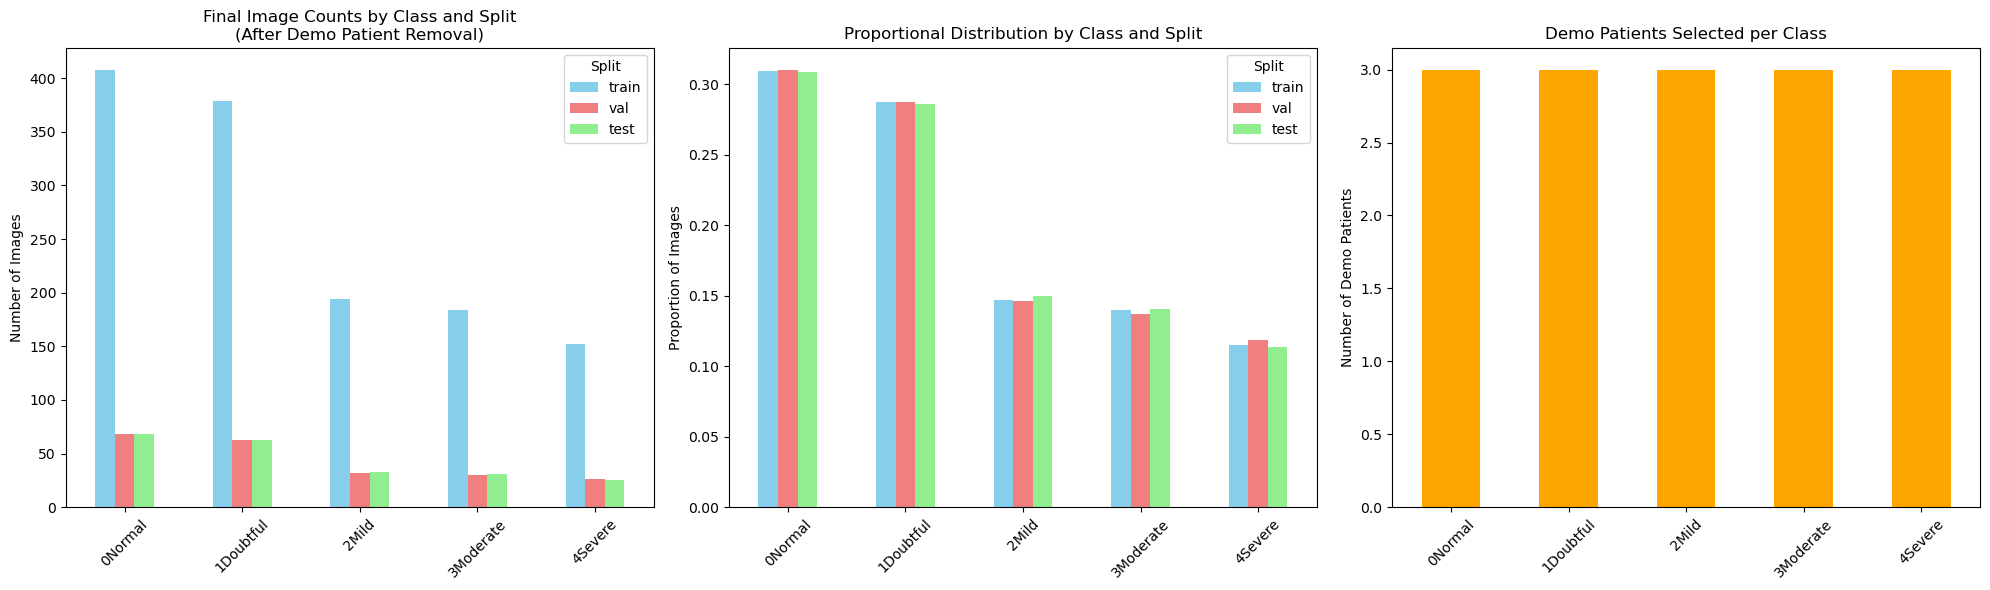

Excellent class balance maintained (std < 1%)

Final dataset structure at: osteoarthritis-severity/data/consensus
  train/: 1317 images
  val/: 219 images
  test/: 220 images
  demo_patients/: 15 images
  expert_disagreements/: 32 images


In [13]:
# Execute dataset creation with demo patients
if KAGGLE_DIR.exists() and 'consensus_files' in locals():
    print("Creating consensus dataset with demo patients and stratified splits...")
    
    # Clear existing consensus directory if it exists
    if CONSENSUS_DIR.exists():
        print(f"Clearing existing consensus directory: {repo_name}/data/consensus")
        shutil.rmtree(CONSENSUS_DIR)
    
    # Create the consensus dataset with demo patients
    dataset_stats = create_consensus_dataset_with_demo(consensus_files, disagreement_files, CONSENSUS_DIR)
    
    print(f"\nDataset creation complete")
    print(f"Summary:")
    print(f"  • Total consensus images: {dataset_stats['total_consensus']}")
    print(f"  • Total disagreement images: {dataset_stats['total_disagreements']}")
    print(f"  • Total demo patients: {dataset_stats['total_demo_patients']}")
    print(f"  • Total training pool: {dataset_stats['total_training_pool']}")
    
    # Display demo patient statistics
    print(f"\nDemo Patients Selected:")
    for class_name, count in dataset_stats['demo_patients'].items():
        print(f"  • {class_name}: {count} patients")
    
    # Display split statistics
    print(f"\nFinal Training Splits:")
    for split, class_counts in dataset_stats['splits'].items():
        total = sum(class_counts.values())
        print(f"  • {split.capitalize()}: {total} images")
        for class_name, count in class_counts.items():
            print(f"    - {class_name}: {count}")
    
    # Display disagreement statistics
    print(f"\nExpert disagreements:")
    for expert, class_counts in dataset_stats['disagreements'].items():
        total = sum(class_counts.values()) if class_counts else 0
        print(f"  • {expert}: {total} images")
        for class_name, count in class_counts.items():
            print(f"    - {class_name}: {count}")
    
    # Verify class balance with demo impact
    verify_split_balance_with_demo(dataset_stats)
    
    # Final verification - check the created directory structure
    print(f"\nFinal dataset structure at: {repo_name}/data/consensus")
    for split in ['train', 'val', 'test']:
        split_dir = CONSENSUS_DIR / split
        if split_dir.exists():
            total_images = sum(len(list(class_dir.glob('*'))) for class_dir in split_dir.iterdir() if class_dir.is_dir())
            print(f"  {split}/: {total_images} images")
    
    # Demo patients directory
    demo_dir = CONSENSUS_DIR / 'demo_patients'
    if demo_dir.exists():
        total_demos = sum(len(list(class_dir.glob('*'))) for class_dir in demo_dir.iterdir() if class_dir.is_dir())
        print(f"  demo_patients/: {total_demos} images")
    
    expert_disagree_dir = CONSENSUS_DIR / 'expert_disagreements'
    if expert_disagree_dir.exists():
        total_disagreements = sum(len(list(expert_dir.rglob('*.*'))) for expert_dir in expert_disagree_dir.iterdir() if expert_dir.is_dir())
        print(f"  expert_disagreements/: {total_disagreements} images")

else:
    print("Skipping dataset creation - missing Kaggle data or consensus analysis")


## Image Preprocessing & Quality Control <a id="preprocessing"></a>

Final image preprocessing steps to prepare the dataset for PyTorch training and ensure consistent formatting across all splits.

### Preprocessing Pipeline
1. **Color Check** – Convert any remaining RGB images to grayscale
2. **Cropping** – Remove padding and isolate the knee joint
3. **Centering** – Align the joint space within a square canvas
4. **Resizing** – Standardize all images to 224×224 resolution
5. **Visual Inspection** – Manually verify preprocessing consistency


In [14]:
def preprocess_xray_image(image, threshold=130, target_size=(224, 224)):
    """
    Preprocess X-ray image with optimized knee-focused cropping.
    
    Args:
        image (np.ndarray): Input grayscale or RGB image
        threshold (int): Pixel intensity threshold for cropping
        target_size (tuple): Final (height, width) for resizing
    
    Returns:
        Preprocessed image (np.ndarray)
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    h, w = image.shape
    
    # Step 1: Find bounding box of non-zero pixels
    mask = image > threshold
    coords = np.argwhere(mask)
    
    if coords.size == 0:
        # Handle completely black image
        cropped = np.ones((100, 100), dtype=image.dtype) * 128
    else:
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        bbox_h, bbox_w = y1 - y0, x1 - x0
        
        # Step 2: Calculate center of mass for better knee centering
        roi = image[y0:y1, x0:x1]
        moments = cv2.moments(roi)
        if moments['m00'] > 0:
            cx = int(moments['m10'] / moments['m00']) + x0
            cy = int(moments['m01'] / moments['m00']) + y0
        else:
            # Fallback to geometric center
            cx = x0 + bbox_w // 2
            cy = y0 + bbox_h // 2
        
        # Step 3: Focus on joint space between femur and tibia
        # Analyze horizontal intensity profile to find the joint space gap
        middle_x = x0 + bbox_w // 2
        middle_strip = roi[:, bbox_w//3:2*bbox_w//3]  # Use middle third for analysis
        horizontal_profile = np.mean(middle_strip, axis=1)
        
        # Find the minimum intensity area (joint space appears darker)
        # Look in the middle 60% of the bone structure
        search_start = int(bbox_h * 0.2)
        search_end = int(bbox_h * 0.8)
        if search_end > search_start:
            search_region = horizontal_profile[search_start:search_end]
            min_idx = np.argmin(search_region) + search_start
            joint_space_y = y0 + min_idx
        else:
            # Fallback to anatomical estimate
            joint_space_y = y0 + int(bbox_h * 0.4)
        
        # Focus on the detected joint space
        focus_y = joint_space_y
        
        # Step 4: Adaptive crop size based on image characteristics
        # Analyze the image to determine optimal zoom level
        
        # Method 1: Bone density analysis
        bone_density = np.mean(roi[roi > threshold])
        density_ratio = bone_density / 255.0
        
        # Method 2: Joint space gap analysis
        gap_prominence = np.std(horizontal_profile)
        gap_ratio = gap_prominence / np.mean(horizontal_profile)
        
        # Method 3: Aspect ratio of bone structure
        aspect_ratio = bbox_w / bbox_h
        
        # Adaptive crop factor based on multiple criteria
        base_crop_factor = 0.75  # Start with 75% as baseline
        
        # Adjust based on bone density (higher density = can zoom in more)
        if density_ratio > 0.7:  # High density bones
            density_adjustment = -0.05  # Zoom in slightly
        elif density_ratio < 0.5:  # Lower density bones
            density_adjustment = +0.05  # Zoom out slightly
        else:
            density_adjustment = 0
        
        # Adjust based on joint gap prominence (clearer gap = can zoom in more)
        if gap_ratio > 0.15:  # Very clear joint space
            gap_adjustment = -0.05  # Zoom in more
        elif gap_ratio < 0.08:  # Less clear joint space
            gap_adjustment = +0.1   # Zoom out more for context
        else:
            gap_adjustment = 0
        
        # Adjust based on aspect ratio (wider bones might need less zoom)
        if aspect_ratio > 1.2:  # Wide bone structure
            aspect_adjustment = +0.05  # Zoom out slightly
        else:
            aspect_adjustment = 0
        
        # Calculate final adaptive crop factor
        adaptive_crop_factor = base_crop_factor + density_adjustment + gap_adjustment + aspect_adjustment
        adaptive_crop_factor = np.clip(adaptive_crop_factor, 0.6, 0.9)  # Keep within reasonable bounds
        
        crop_size = int(max(bbox_w, bbox_h) * adaptive_crop_factor)
        
        # Optional: Debug output (uncomment to see adaptive decisions)
        # print(f"Density: {density_ratio:.3f}, Gap: {gap_ratio:.3f}, Aspect: {aspect_ratio:.3f}")
        # print(f"Adjustments - Density: {density_adjustment:+.3f}, Gap: {gap_adjustment:+.3f}, Aspect: {aspect_adjustment:+.3f}")
        # print(f"Final crop factor: {adaptive_crop_factor:.3f}")
        
        # Step 5: Center the crop around the focus point
        crop_x = max(0, min(w - crop_size, cx - crop_size // 2))
        crop_y = max(0, min(h - crop_size, focus_y - crop_size // 2))
        
        # Step 6: Extract the cropped region
        actual_crop_h = min(crop_size, h - crop_y)
        actual_crop_w = min(crop_size, w - crop_x)
        cropped_region = image[crop_y:crop_y+actual_crop_h, crop_x:crop_x+actual_crop_w]
        
        # Step 7: Pad to square if needed
        if cropped_region.shape[0] < crop_size or cropped_region.shape[1] < crop_size:
            padded = np.zeros((crop_size, crop_size), dtype=image.dtype)
            h_crop, w_crop = cropped_region.shape
            y_pad = (crop_size - h_crop) // 2
            x_pad = (crop_size - w_crop) // 2
            padded[y_pad:y_pad+h_crop, x_pad:x_pad+w_crop] = cropped_region
            cropped = padded
        else:
            cropped = cropped_region
    
    # Step 8: Resize to target size
    resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
    
    return resized

def apply_preprocessing_to_dataset(data_dir, backup_original=True):
    """
    Apply preprocessing to all images in the dataset.
    
    Args:
        data_dir: Directory containing the dataset
        backup_original: Whether to backup original images
    
    Returns:
        Processing statistics
    """
    data_dir = Path(data_dir)
    stats = {
        'processed': 0,
        'errors': 0,
        'backed_up': 0
    }
    
    print(f"Preprocessing images in: {repo_name}/data/consensus")
    
    # Create backup directory if needed
    if backup_original:
        backup_dir = data_dir.parent / f"{data_dir.name}_original_backup"
        backup_dir.mkdir(exist_ok=True)
    
    # Process all images
    for img_path in data_dir.rglob('*'):
        if img_path.suffix.lower() in IMG_EXTS:
            try:
                # Backup original if requested
                if backup_original:
                    backup_path = backup_dir / img_path.relative_to(data_dir)
                    backup_path.parent.mkdir(parents=True, exist_ok=True)
                    shutil.copy2(img_path, backup_path)
                    stats['backed_up'] += 1
                
                # Load and preprocess image
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                
                processed_img = preprocess_xray_image(img, target_size=TARGET_SIZE)
                
                # Save preprocessed image
                cv2.imwrite(str(img_path), processed_img)
                stats['processed'] += 1
                
                # Show progress only at major milestones to reduce output verbosity
                if stats['processed'] % 500 == 0:
                    print(f"  Progress: {stats['processed']} images processed...")
                    
            except Exception as e:
                print(f"Error processing {img_path.name}: {e}")
                stats['errors'] += 1
    
    return stats

def preview_preprocessing(data_dir, n_samples=5):
    """
    Preview preprocessing results by comparing original and processed images.
    """
    # Find sample images
    sample_images = []
    for img_path in Path(data_dir).rglob('*'):
        if img_path.suffix.lower() in IMG_EXTS and len(sample_images) < n_samples:
            sample_images.append(img_path)
    
    if not sample_images:
        print("No images found for preview")
        return
    
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 3*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, img_path in enumerate(sample_images):
        # Load original
        original = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        # Apply preprocessing
        processed = preprocess_xray_image(original, target_size=TARGET_SIZE)
        
        # Display original
        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title(f"Original: {img_path.name}\n{original.shape}")
        axes[i, 0].axis('off')
        
        # Display processed
        axes[i, 1].imshow(processed, cmap='gray')
        axes[i, 1].set_title(f"Processed\n{processed.shape}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Image preprocessing functions defined")


Image preprocessing functions defined


Starting advanced image preprocessing pipeline...

Step 1: Preprocessing preview


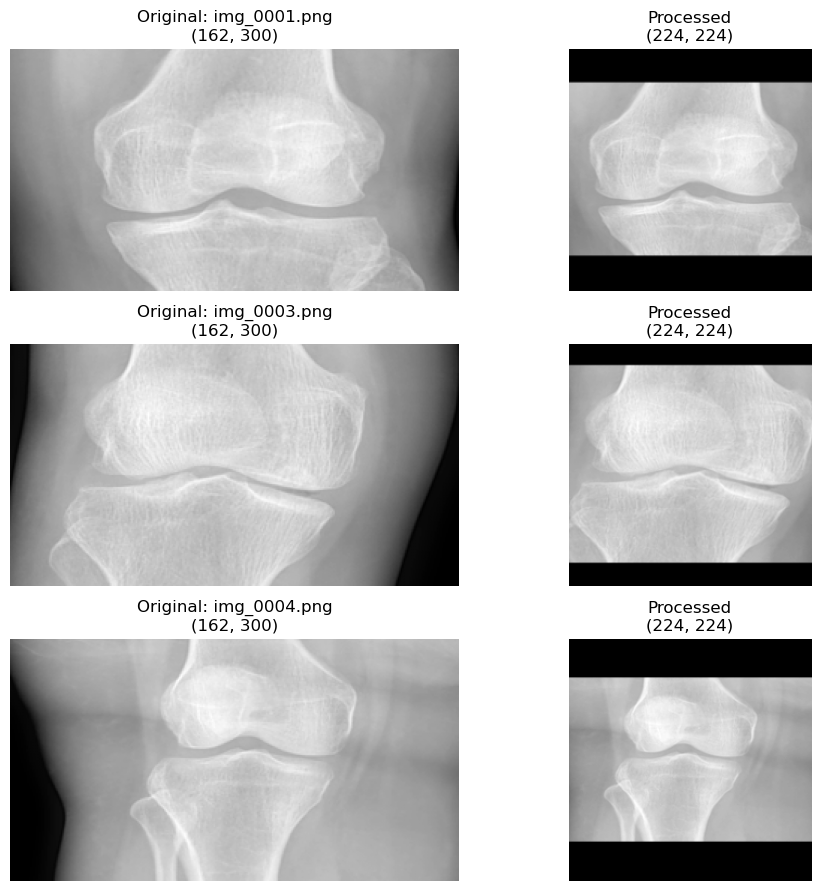


Step 2: Applying advanced preprocessing to entire dataset
(Color conversion was already completed earlier in the pipeline)
Preprocessing images in: osteoarthritis-severity/data/consensus
  Progress: 500 images processed...
  Progress: 1000 images processed...
  Progress: 1500 images processed...

Advanced preprocessing complete
Statistics:
  • Images processed: 1803
  • Errors encountered: 0
  • Images backed up: 0

Final preprocessed dataset at: osteoarthritis-severity/data/consensus
=== File extensions ===
    .png : 1803
   .json : 1

=== Image dimensions (WxH) ===
224×224 : 1803


In [15]:
# Execute advanced preprocessing on consensus dataset
if CONSENSUS_DIR.exists():
    print("Starting advanced image preprocessing pipeline...")
    
    # Step 1: Preview preprocessing effects
    print("\nStep 1: Preprocessing preview")
    preview_preprocessing(CONSENSUS_DIR / 'train', n_samples=3)
    
    # Step 2: Apply preprocessing to entire dataset
    print("\nStep 2: Applying advanced preprocessing to entire dataset")
    print("(Color conversion was already completed earlier in the pipeline)")
    preprocessing_stats = apply_preprocessing_to_dataset(CONSENSUS_DIR, backup_original=False)
    
    print(f"\nAdvanced preprocessing complete")
    print(f"Statistics:")
    print(f"  • Images processed: {preprocessing_stats['processed']}")
    print(f"  • Errors encountered: {preprocessing_stats['errors']}")
    print(f"  • Images backed up: {preprocessing_stats['backed_up']}")
    
    # Final dataset summary
    print(f"\nFinal preprocessed dataset at: {repo_name}/data/consensus")
    summarize_files(CONSENSUS_DIR)
    
else:
    print("Skipping preprocessing - consensus dataset not found")


## Summary and Next Steps <a id="summary"></a>

### Data Preparation Pipeline Complete

This notebook transformed the raw Kaggle knee X-ray dataset into a standardized, model-ready format suitable for training and downstream clinical applications. The pipeline includes:

#### **1. Dataset Exploration & Consensus Resolution**
- Analyzed 3,300 knee X-rays from two expert annotators
- Identified 1,771 consensus images with matching severity labels
- Excluded 32 disagreement cases
- Split wide dual-knee images into single-knee format
- Converted RGB images to grayscale for consistency

#### **2. Demo Patient Profiles**
- Selected 15 demo patients (3 per severity class) from consensus data
- Generated metadata capturing demographics, comorbidities, and treatment context
- Designed patient profiles for use in downstream clinical decision support and LLM inference

#### **3. Stratified Splitting & Integrity Checks**
- Applied 75/12.5/12.5 train/val/test stratified split
- Removed demo patients from training to prevent leakage
- Validated class balance with statistical checks and visualizations

#### **4. Preprocessing & Standardization**
- Applied joint-centric cropping, adaptive zoom, and centering
- Standardized all images to 224×224 resolution
- Prepared data for PyTorch pipelines with consistent formatting

---

### **Final Dataset Structure**

```
data/consensus/
├── demo_patients/         # 15 curated patients for clinical showcase
│   ├── 0Normal/           # 3 patients (ages 28-72, diverse demographics)
│   ├── 1Doubtful/         # 3 patients (varied occupations, activity levels)
│   ├── 2Mild/             # 3 patients (progression complexity examples)
│   ├── 3Moderate/         # 3 patients (treatment decision scenarios)
│   └── 4Severe/           # 3 patients (advanced intervention needs)
├── train/                 # 75% - Training images (consensus, ~1,317 images)
├── val/                   # 12.5% - Validation images (consensus, ~220 images)
├── test/                  # 12.5% - Test images (consensus, ~220 images)
└── expert_disagreements/  # 32 images excluded due to disgreement
```

---

### **Clinical Decision Support Pipeline**

The processed dataset enables:

**1. Multi-Class Classification Models**
- 5-class severity assessment (Normal, Doubtful, Mild, Moderate, Severe)
- CNN architectures optimized for medical imaging (ResNet, EfficientNet, DenseNet)
- Transfer learning from ImageNet with medical domain adaptation

**2. Production Deployment & Clinical Integration**
- Streamlit web application for healthcare professionals
- Real-time X-ray analysis with confidence scoring
- Integration with clinical workflows and PACS systems

**3. LLM-Powered Treatment Recommendations**
- Patient-specific treatment plans based on severity assessment
- Evidence-based recommendations following ACR/EULAR guidelines
- Personalized care considering patient demographics and medical history

---

### **Key Technical Achievements**

- **1,771 Expert Consensus Images**: High-quality training data with validated labels
- **Class Balance Maintained**: Via stratified sampling
- **224×224 Standardized Format**: PyTorch-ready with consistent preprocessing
- **Metadata-driven demo patients** enable real-world simulation

**This data preparation pipeline establishes the foundation for accurate, clinically-validated osteoarthritis severity classification and intelligent treatment planning.**
